In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, T_no, H_no, layer_no, in_no, sub_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.H_no = H_no
        self.layer_no = layer_no
        self.in_no = in_no
        self.device = device
        self.sub_no = sub_no
        
        #self.lstm = nn.GRU(self.in_no, self.H_no, self.layer_no, batch_first=True)
        #self.linear = nn.Linear(self.H_no, 1)
        
        self.scale = nn.Parameter(torch.ones(self.in_no), requires_grad=True)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(nn.GRU(1, self.H_no, self.layer_no, batch_first=True))
            self.linear.append(nn.Linear(self.H_no, 1))
        
        self.clust_raw = nn.Parameter(torch.zeros(self.sub_no, self.in_no), requires_grad=True)
        
    def forward(self, S, temp, test):
        T_data = S.shape[0]
        
        S = S * self.scale.reshape(1,-1)
        
        if test == False:
            W_clust = F.softmax(self.clust_raw/temp, 0)
        elif test == True:
            W_clust = torch.zeros_like(self.clust_raw).to(self.device)
            for i in range(W_clust.shape[1]):
                idx = torch.argmax(self.clust_raw[:,i])
                W_clust[idx,i] = 1
        
        sub_out = torch.zeros(T_data, self.sub_no).to(self.device)
        
        for s in range(self.sub_no):
            sub_in = torch.matmul(S, W_clust[s]) #(T_data)
            rnn_out, _ = self.rnn[s](sub_in.reshape(1,-1,1))
            sub_out[:,s] = sub_out[:,s] + self.linear[s](rnn_out.squeeze(0)).flatten()
        
        final = torch.sum(sub_out, 1)
        
        return final, sub_out, W_clust

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep150_stimseed1.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 999 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 501
H_no = 20
layer_no = 1
sub_no = 4
#in_no = e_idx.shape[0] + i_idx.shape[0]
in_no = 299
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 50000
iter_no = 20000
epoch_no = iter_no*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = GenericGRU(T_no, H_no, layer_no, in_no, sub_no, device)

param1 = []
param2 = []

for p in model.parameters():
    if p.shape == (sub_no, in_no):
        param2.append(p)
    else:
        param1.append(p)

#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
optimizer = torch.optim.Adam(param1, lr = 0.005)
optimizer_clust = torch.optim.Adam(param2, lr = 0.0025)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_clust, step_size=50, gamma=0.944)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

7099


In [7]:
temp_list = np.logspace(-0.5, -3, 50)
temp_count = 0
#print(temp_list)

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    optimizer_clust.zero_grad()
    
    if (i%50 == 49) & (temp_count < 49):
        temp_count += 1
        print(temp)
    temp = temp_list[temp_count] 
    
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    #V_pred, _, __ = model(torch.hstack((batch_E_neural[:,e_idx], batch_I_neural[:,i_idx])), temp, False)
    V_pred, _, __ = model(batch_E_neural[:,e_idx], temp, False)
    #V_pred = model(torch.hstack((batch_E_neural, batch_I_neural)))
    
    train_score = explained_variance_score(batch_V.cpu().detach().numpy(), V_pred.cpu().detach().numpy())
            
    #loss = torch.var(V_pred - batch_V)
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer_clust.step()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        #test_V_pred, test_sub_out, test_W_clust = model(torch.hstack((test_E_neural[:,e_idx], test_I_neural[:,i_idx])), temp, True)
        test_V_pred, test_sub_out, test_W_clust = model(test_E_neural[:,e_idx], temp, True)
        #test_V_pred = model(torch.hstack((test_E_neural, test_I_neural)))
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
        
        clust_loss = torch.mean(torch.abs(test_W_clust[:,1:] - test_W_clust[:,:-1])).item()
        
        print(i, np.round(test_score,6),
              np.round(test_mse,6),
              np.round(train_score,6),
              np.round(loss.item(),6),
              np.round(clust_loss,6))


<ipython-input-7-fb031617865c>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 0.023256 0.115747 0.015008 0.270482 0.003356
0.31622776601683794
49 0.064717 0.025948 0.051837 0.022119 0.015101
0.28117686979742307
99 0.13574 0.024557 0.174159 0.026817 0.09396
0.250011038261793
149 0.063702 0.026373 0.22123 0.022378 0.134228
0.22229964825261944
199 0.152808 0.023444 0.249779 0.018306 0.104027
0.19765980717016338
249 0.188466 0.022448 0.260847 0.02348 0.105705
0.1757510624854792
299 0.183806 0.022835 0.265947 0.018129 0.114094
0.15627069765469953
349 0.203521 0.021951 0.305577 0.015354 0.100671
0.13894954943731375
399 0.196464 0.022129 0.274479 0.019013 0.107383
0.12354828882567469
449 0.216192 0.021646 0.260374 0.020932 0.104027
0.10985411419875583
499 0.217789 0.021563 0.245587 0.021889 0.097315
0.09767781100894893
549 0.220392 0.021419 0.273671 0.017193 0.115772
0.08685113737513525
599 0.226534 0.021361 0.241734 0.027939 0.110738
0.07722449945836259
649 0.223483 0.02163 0.29345 0.024604 0.100671
0.06866488450043001
699 0.228896 0.021179 0.322951 0.020279 0.12080

KeyboardInterrupt: 

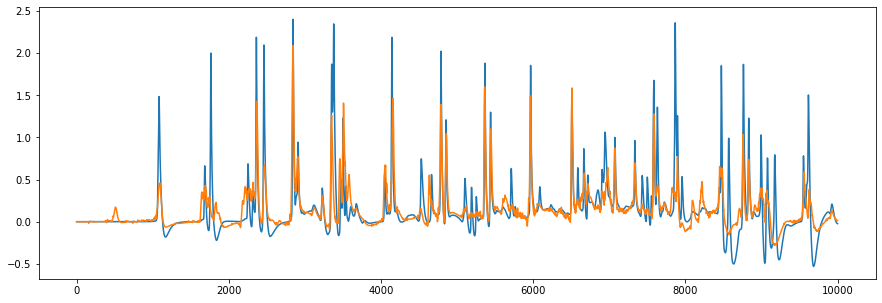

In [12]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])
#plt.plot(lin_out.flatten().cpu().detach().numpy()[16000:26000])

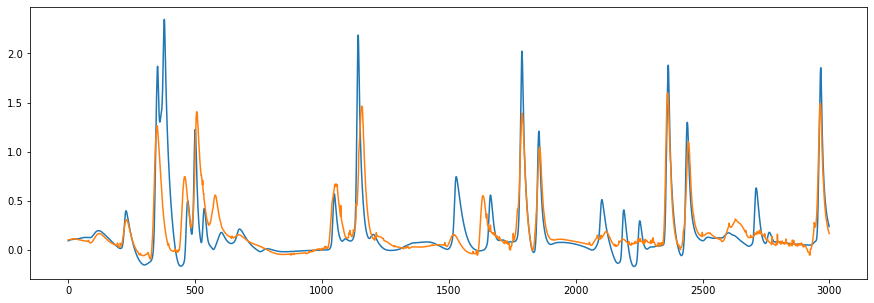

In [13]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:6000])

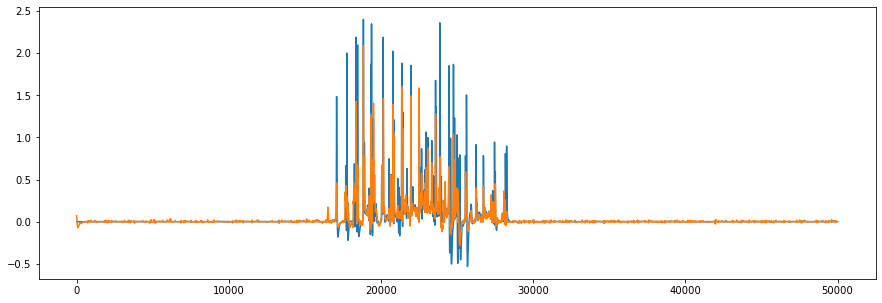

In [14]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())

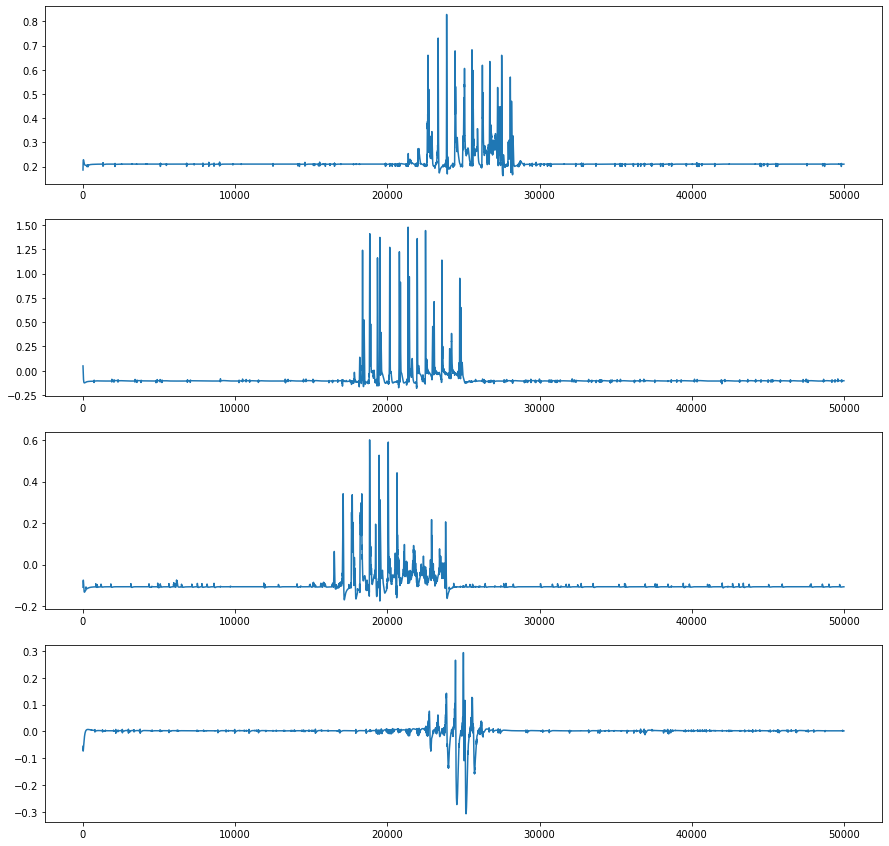

In [15]:
fig, axs = plt.subplots(nrows=sub_no, figsize = (15,15))
for i in range(sub_no):
    axs[i].plot(test_sub_out[:,i].cpu().detach().numpy())

In [12]:
scale = model.scale.cpu().detach().numpy()

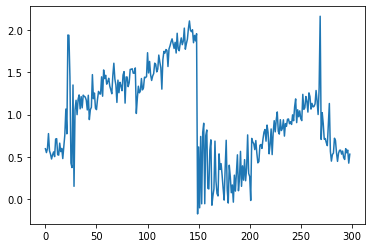

In [13]:
plt.plot(scale)

In [8]:
raw = model.clust_raw
syn = torch.zeros(raw.shape[1])
for i in range(syn.shape[0]):
    idx = torch.argmax(raw[:,i])
    syn[i] = idx
    
C_syn = syn.cpu().detach().numpy()
true = eloc[e_idx,0]

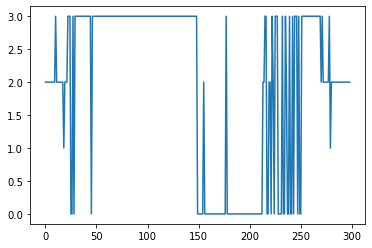

In [9]:
plt.plot(C_syn)

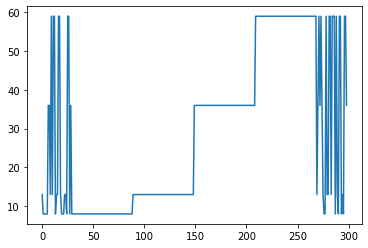

In [10]:
plt.plot(true)

In [11]:
torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/gru_s4_h20_spat_v3.pt")